In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.integrate as si
import numpy.linalg as npla



import pandas as pd
from scipy.sparse.csc import csc_matrix

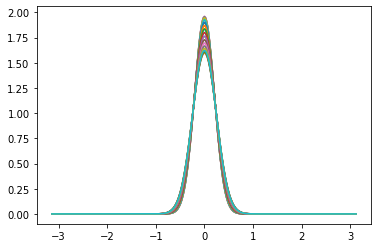

2.2380840534695828e-17


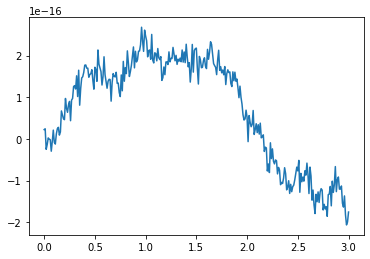

[ 0.00000000e+00+0.j -8.90629255e-18+0.j -2.38912792e-17+0.j
 -1.19130111e-17+0.j -1.26462729e-17+0.j -9.10133050e-18+0.j
  2.95566445e-18+0.j  7.68976626e-18+0.j  9.61080692e-18+0.j
 -5.13595171e-18+0.j  3.07038223e-18+0.j  2.98917781e-18+0.j
  5.83381479e-18+0.j  5.43350338e-18+0.j  3.80187278e-18+0.j
  2.76409236e-18+0.j  2.59062855e-18+0.j -6.45033954e-18+0.j
 -7.00517469e-18+0.j -1.54065860e-18+0.j -5.11869144e-18+0.j
 -5.52868820e-18+0.j  7.63595342e-19+0.j -1.37818015e-17+0.j
 -1.25030813e-17+0.j -5.43935219e-18+0.j -3.09785942e-18+0.j
  1.09078439e-17+0.j  2.37946284e-17+0.j  1.89133735e-17+0.j
  8.66587184e-18+0.j  7.10031457e-18+0.j -6.26477369e-20+0.j
  1.21734649e-17+0.j  4.70306079e-18+0.j  7.49796104e-18+0.j
  7.99741103e-18+0.j  1.02644332e-17+0.j  2.02764708e-17+0.j
  2.24738113e-17+0.j  1.28458486e-17+0.j  2.44086894e-17+0.j
  7.99192270e-18+0.j  8.81702572e-18+0.j  1.17063128e-17+0.j
  1.78070682e-17+0.j  8.47881597e-18+0.j  1.55159235e-17+0.j
  2.22862368e-17+0.j  2.

C:\Users\reddf\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


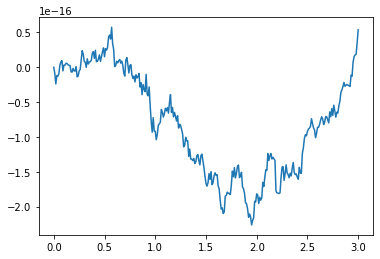

[-6.95206557e-12+9.41593632e-12j -6.95200875e-12+9.47111637e-12j
 -6.94924568e-12+9.63647292e-12j -6.93898421e-12+9.91446985e-12j
 -6.91843368e-12+1.03100626e-11j -6.88388325e-12+1.08342546e-11j
 -6.82417499e-12+1.14989695e-11j -6.72779017e-12+1.23146168e-11j
 -6.58538341e-12+1.33005930e-11j -6.38037195e-12+1.44857579e-11j
 -6.09183671e-12+1.58986424e-11j -5.69844101e-12+1.75738897e-11j
 -5.17183614e-12+1.95615478e-11j -4.48020463e-12+2.19229041e-11j
 -3.59015315e-12+2.47326059e-11j -2.45789184e-12+2.80865166e-11j
 -1.03406155e-12+3.21030600e-11j  7.30891391e-13+3.69301446e-11j
  2.89519872e-12+4.27574214e-11j  5.52289498e-12+4.98225938e-11j
  8.67345318e-12+5.84214798e-11j  1.24008535e-11+6.89306807e-11j
  1.67509252e-11+8.18300479e-11j  2.17498801e-11+9.77187597e-11j
  2.73826981e-11+1.17349430e-10j  3.35663629e-11+1.41683627e-10j
  4.01207490e-11+1.71936075e-10j  4.67160107e-11+2.09629078e-10j
  5.27946678e-11+2.56691260e-10j  5.74718863e-11+3.15562345e-10j
  5.93863238e-11+3.893089

In [2]:
#Wigner/Husini function implementation
#Particle on ring Dimensionless


#variables
Omeg0=1.0
Omeg1=1.0
eps=0.0
ntild=10#ntild = 1 is quantum, ntild>>1 is classical
dt=0.01
nsteps=300
isteps=300

t0=0
theta0=0#+0.1
thetamin=-np.pi
thetamax=np.pi
k=1j

#dependent variables
dtheta=(2*thetamax)/isteps
sigma=0.5

#initial arrays 
theta=np.zeros(isteps)
drv=np.zeros(nsteps+1)
t=np.zeros(nsteps+1)
   
for n in range(nsteps+1):#t,drv array, drv is drive force
    tn=t0+(n)*dt
    t[n]=tn
    drvn=np.cos(Omeg1*tn)
    drv[n]=drvn

T=np.zeros(isteps,np.complex)#wave packet array

for i in range(0,isteps):#theta,initial wave packet array T
    thetai=thetamin+(i)*dtheta
    theta[i]=thetai
    Ti=np.exp((-0.0*k*thetai)+(-1)*((thetai-theta0)**2)/(sigma)**2)
    T[i]=Ti
    
#probibility here, to normalize
Total=np.sum(np.abs(T)**2)*dtheta
T=T/(np.sqrt(Total))
#make array of arrays of T
Tn=[]
Tn.append(T)

#definitions of coeffients
def a(drv,theta):
    a1=((1/(ntild*2*2*(dtheta)**2))-((k*eps*(Omeg0/Omeg1)*drv[n])/(dtheta)))
    return a1
def b(drv,theta):
    b1=((k/(Omeg0*dt))+(1/(ntild*2*(dtheta)**2))+((eps**2)/2+(Omeg0**2)/(Omeg1**2)*ntild*(drv[n])**2/4)-(ntild*np.cos(theta)/2))#cos has flipped signs, fix this and correct the potential
    return b1 
def c(drv,theta):
    c1=((1/(ntild*2*2*(dtheta)**2))+((k*eps*(Omeg0/Omeg1)*drv[n])/(dtheta)))
    return c1

def a_1(drv,theta):
    a_11=((1/(ntild*2*2*(dtheta)**2))-((k*eps*(Omeg0/Omeg1)*drv[n+1])/(dtheta)))
    return a_11
def b_1(drv,theta):
    b_11=((k/(Omeg0*dt))-(1/(ntild*2*(dtheta)**2))-((eps**2)/2+(Omeg0**2)/(Omeg1**2)*ntild*(drv[n+1])**2/4)+(ntild*np.cos(theta)/2))#cos has flipped signs, fix this and correct the potential
    return b_11
def c_1(drv,theta):
    c_11=((1/(ntild*2*2*(dtheta)**2))+((k*eps*(Omeg0/Omeg1)*drv[n+1])/(dtheta)))
    return c_11

def CrankNicolson(T,n):#Crank nicolson solver with periodic boundary conditions
    RHS=np.zeros(isteps,np.complex)#RHS
    for i in range(-1,isteps-1):
        temp1=-a(drv,theta[i])
        temp2=b(drv,theta[i])
        temp3=-c(drv,theta[i])
        RHS[i]=temp1*T[i+1]+temp2*T[i]+temp3*T[i-1]
    D=np.matrix(RHS).T#made matrix for the RHS
    d=np.zeros((isteps,isteps),np.complex)#LHS
    for i in range(-1,isteps-1):
        d[i,i]=b_1(drv,theta[i])
        d[i,i+1]=a_1(drv,theta[i])
        d[i,i-1]=c_1(drv,theta[i])
    d=np.matrix(d)#made matrix for LHS
    I=npla.inv(d)#matrix inversion using linear algebra 
    T1=I*D
    T1=np.array(T1.T)[0]#add to array of T
    return T1

#plt.plot(theta,np.real(T))# plots initial condition
#Run for all t
for n in range(nsteps):#Plots real parts                                                                  
    T=CrankNicolson(T,n)
    Tn.append(T)
 #   plt.plot(theta,np.real(T))
    
#plt.show() 

#for T in Tn:#Plots imaginary parts
  #  plt.plot(theta,np.imag(T))

#plt.show()

#for T in Tn:#plots overall average
   # plt.plot(theta,np.abs(T)**2)
   #print(np.sum(np.abs(T)**2)*dtheta)#checking for unitarity

for n in range(0,nsteps,10):
    plt.plot(theta,np.abs(Tn[n])**2)

plt.show()

#Expecatation values

def position(theta,T):#calculates expectation value
    TA=0.
    for i in range(isteps):
        TA=TA+theta[i]*(np.abs(T[i])**2)*dtheta
    return TA

xbar=np.zeros(nsteps+1)
for n in range(nsteps+1):
    xbar[n]=np.real(position(theta,Tn[n]))
    
print(xbar[0])
plt.plot(t,xbar)
plt.show()

#angular momentum value, this works as long as Omeg0=1, which it does
Exp_momentum=np.zeros((nsteps+1,2),np.complex)
def momentum(T):#calculates expectation value
    P=0.
    for i in range(-1,isteps-1):
        P=P+(1)*(-k)*(Omeg0/ntild)*np.conj(T[i])*((T[i+1]-T[i-1])/(2*dtheta))*dtheta
    return(P)

pbar=np.zeros((nsteps+1),np.complex)
#
for n in range(nsteps+1):
    pbar[n]=np.real(momentum(Tn[n]))
    Exp_momentum[n,0]=t[n]#time
    Exp_momentum[n,1]=momentum(Tn[n])#expectation value of momentum

Exp_momentum=np.matrix(Exp_momentum)#table showing time and expectation value
print(pbar)
plt.plot(t,pbar)
plt.show()

print(T)

print(len(theta))

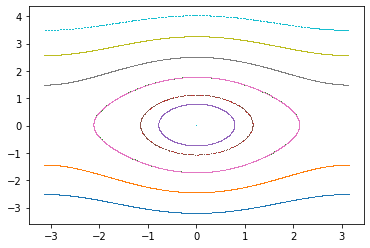

In [3]:
#variables in the classical scheme
tn=0
xn=0# Theta initial
vn=0# Omega/ angular velocity initial
nsteps=1000000
v=np.zeros(nsteps)
x=np.zeros(nsteps)
t=np.zeros(nsteps)
isteps=10# number of initial conditions we need
i=1+isteps
V=[]
X=[]
T=[]

def Verlet(tn,xn,vn,dt):#velocity verlet algorithim
    tn1=tn+dt
    an=(-Omeg0**2)*math.sin(xn)+eps*math.sin(Omeg1*tn)
    xn1=xn+vn*dt+(1/2)*an*dt**2# position
    an1=(-Omeg0**2)*math.sin(xn1)+eps*math.sin(Omeg1*tn1)# acceleration
    vn1=vn+(1/2)*(an+an1)*dt# velocity
    return tn1,xn1,vn1

ICsP=int((2*np.pi)/(dt*Omeg1))
Max=nsteps-ICsP

for i in range(10):
    P_X=np.zeros(nsteps)#Max-ICsP)
    P_V=np.zeros(nsteps)#Max-ICsP)
    tn=0
    xn=(np.pi/4)#*i
    vn=(np.pi/4)*(i-4)
    for n in range(nsteps):#looping verlet to get values
        tn, xn, vn = Verlet(tn,xn,vn,dt)
        x[n]=xn
        v[n]=vn
        t[n]=tn
    X.append(x)
    V.append(v)
    T.append(t)
    for j in range(ICsP,Max,ICsP): # turn this loop into the POINCARE SURFACES
        P_X[j-ICsP] = X[i][j]
        P_V[j-ICsP] = V[i][j]
        P_X=((P_X+np.pi)%(2*np.pi))-np.pi
    plt.plot(P_X,P_V,',')
plt.show()


In [4]:
print(len(theta))
print(max(pbar))
omega=np.linspace(-max(pbar),max(pbar),len(theta))
theta=theta
r=np.linspace(-np.pi,np.pi,len(theta))

#print(omega)
print(len(theta))
#psi=CrankNicolson(T,n)

dr=1

omega1,theta1,r1=np.meshgrid(omega,theta,r)
omega2,theta2=np.meshgrid(omega,theta)
#theta3,x3=np.meshgrid(theta,x)
#print(x1,y1)
#print(x,y)

isteps=len(omega)
jsteps=len(theta)

def Husimi(omega0,theta0,r0):
    return T*np.exp((k*ntild*omega0*r)-(((theta0-r0)**2)/(4*(dr**4))))

func=Husimi(omega1,theta1,r1)

print(func.shape)
print(omega)
print(theta)
#plt.plot(z)
#plt.show()

#plt.contour(x1,y1,z)
#plt.show()


#print(x[0])
#print(z)
print(omega.shape)
print(theta.shape)
#print(z.shape)


Int=np.zeros((isteps,jsteps),np.complex)
for i in range(isteps):
    for j in range(jsteps):
        Int[i,j]=si.simps(func[j,:,i],r)#,np.pi/2,-1,'avg')
        
print(Int)
print(Int.shape)
print(omega2.shape)

plt.contour(np.real(omega2),np.real(theta2),np.abs(Int)**2)#blue
plt.show()



300
(5.746446561913872e-17+0j)
300


ValueError: operands could not be broadcast together with shapes (10,1000000) (300,300,300) 